In [1]:
using MXNet

In [2]:
mlp = @mx.chain mx.Variable(:data)             =>
  mx.FullyConnected(name=:fc1, num_hidden=128) =>
  mx.Activation(name=:relu1, act_type=:relu)   =>
  mx.FullyConnected(name=:fc2, num_hidden=64)  =>
  mx.Activation(name=:relu2, act_type=:relu)   =>
  mx.FullyConnected(name=:fc3, num_hidden=10)  =>
  mx.SoftmaxOutput(name=:softmax)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007fbcfe78f8c0))

In [3]:
# data provider
batch_size = 100
include(Pkg.dir("MXNet", "examples", "mnist", "mnist-data.jl"))
train_provider, eval_provider = get_mnist_providers(batch_size)

(MXNet.mx.MXDataProvider(MXNet.mx.MX_DataIterHandle(Ptr{Void} @0x00007fbcfbd8c270),Tuple{Symbol,Tuple}[(:data,(784,100))],Tuple{Symbol,Tuple}[(:softmax_label,(100,))],100,true,true),MXNet.mx.MXDataProvider(MXNet.mx.MX_DataIterHandle(Ptr{Void} @0x00007fbcfea1fda0),Tuple{Symbol,Tuple}[(:data,(784,100))],Tuple{Symbol,Tuple}[(:softmax_label,(100,))],100,true,true))

In [4]:
using PyPlot

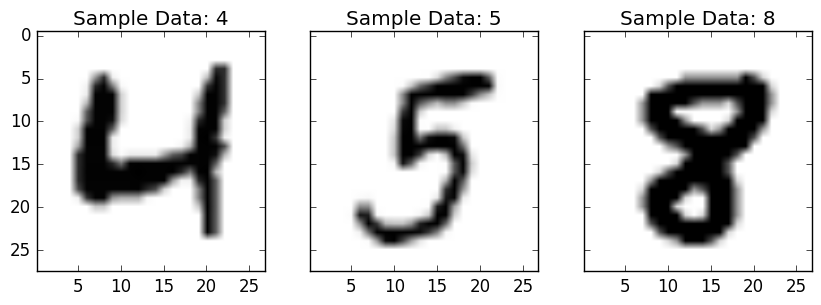

In [5]:
batch = first(train_provider)
images = copy(mx.get(train_provider, batch, :data))[:,1:3]
labels = copy(mx.get(train_provider, batch, :softmax_label))[1:3]

f, axs = PyPlot.subplots(1, 3, sharey=true, figsize=(10, 3))
for i = 1:3
    image = reshape(images[:,i], 28, 28)'
    axs[i][:imshow](image, cmap=get_cmap("Greys"))
    axs[i][:set_title]("Sample Data: $(round(Int, labels[i]))")
end

In [6]:
# setup model
model = mx.FeedForward(mlp, context=mx.cpu())

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007fbcfe78f8c0)),[CPU0],#undef,#undef,#undef)

In [7]:
# optimization algorithm
optimizer = mx.SGD(lr=0.1, momentum=0.9)

MXNet.mx.SGD(MXNet.mx.SGDOptions(0.1,0.9,0,0.0001,MXNet.mx.LearningRate.Fixed(0.1),MXNet.mx.Momentum.Fixed(0.9)),#undef)

In [8]:
# fit parameters
mx.fit(model, optimizer, train_provider, n_epoch=20, eval_data=eval_provider)

INFO: Start training on [CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: Start training...
INFO: == Epoch 001 ==========
INFO: ## Training summary
INFO:           accuracy = 0.7548
INFO:               time = 1.3131 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9498
INFO: == Epoch 002 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9575
INFO:               time = 1.0056 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9678
INFO: == Epoch 003 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9700
INFO:               time = 0.9593 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9689
INFO: == Epoch 004 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9760
INFO:               time = 0.9210 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9694
INFO: == Epoch 005 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9811
INFO:               

In [9]:
probs = mx.predict(model, eval_provider)

10x10000 Array{Float32,2}:
 1.06312e-10  5.80024e-13  2.965e-8     …  4.77526e-11  6.73342e-13
 7.46479e-8   1.50914e-11  0.999939        3.83869e-11  9.10979e-16
 5.39378e-9   1.0          2.33463e-5      2.85017e-13  2.81719e-13
 4.7356e-7    4.01732e-8   8.18917e-10     5.87185e-10  3.66529e-16
 8.03094e-10  2.75113e-16  3.04848e-6      3.1257e-14   2.58185e-13
 2.61006e-9   8.06292e-16  5.892e-9     …  0.999999     1.2713e-11 
 3.00019e-11  6.33867e-15  1.13649e-7      1.09904e-9   1.0        
 0.999999     6.59821e-11  3.33885e-5      2.07988e-12  6.45652e-19
 2.26256e-9   1.24287e-11  1.17842e-6      1.22676e-6   5.31528e-13
 1.94323e-7   3.90443e-21  7.36552e-9      7.82996e-11  1.12308e-19

In [10]:
# collect all labels from eval data
labels = Array[]
for batch in eval_provider
    push!(labels, copy(mx.get(eval_provider, batch, :softmax_label)))
end
labels = cat(1, labels...)

10000-element Array{Float32,1}:
 7.0
 2.0
 1.0
 0.0
 4.0
 1.0
 4.0
 9.0
 5.0
 9.0
 0.0
 6.0
 9.0
 ⋮  
 5.0
 6.0
 7.0
 8.0
 9.0
 0.0
 1.0
 2.0
 3.0
 4.0
 5.0
 6.0

In [11]:
# Now we use compute the accuracy
correct = 0
for i = 1:length(labels)
    # labels are 0...9
    if indmax(probs[:,i]) == labels[i]+1
        correct += 1
    end
end
accuracy = 100correct/length(labels)
println(mx.format("Accuracy on eval set: {1:.2f}%", accuracy))

Accuracy on eval set: 97.99%


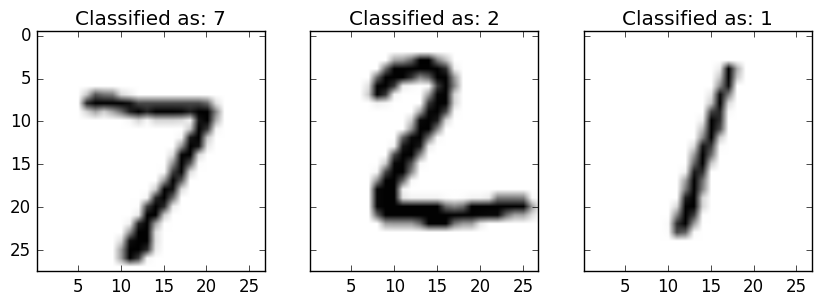

In [12]:
batch = first(eval_provider)
images = copy(mx.get(eval_provider, batch, :data))[:,1:3]

f, axs = PyPlot.subplots(1, 3, sharey=true, figsize=(10, 3))
for i = 1:3
    image = reshape(images[:,i], 28, 28)'
    axs[i][:imshow](image, cmap=get_cmap("Greys"))
    axs[i][:set_title]("Classified as: $(indmax(probs[:,i])-1)")
end